In [ ]:
import pandas as pd

df = pd.read_excel('data.xlsx')

df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


В этой части проекта мы работаем с задачей классификации для показателя SI (Selectivity Index), который важен для оценки безопасности соединений: он показывает, насколько эффективно вещество подавляет вирус, не повреждая при этом клетки. Мы хотим предсказать, превышает ли значение SI медиану, чтобы отобрать лучшие кандидаты для дальнейших исследований.

Мы начнем с проверки распределения классов и, если потребуется, сбалансируем их. Затем обучим несколько моделей (Logistic Regression, Random Forest, XGBoost и другие), чтобы сравнить их работу. Также построим красивые и наглядные визуализации: ROC-кривые, PCA для наглядности разделения классов, какие признаки действительно влияют на селективность соединений.

Такой подход позволяет не только предсказать активность молекул, но и понять, какие химические свойства (например, липофильность, топология, электронная плотность) играют ключевую роль. Это помогает химикам в дальнейшей оптимизации лекарственных кандидатов

In [ ]:
median_si = df['SI'].median()
df['SI_above_median'] = (df['SI'] > median_si).astype(int)

class_counts = df['SI_above_median'].value_counts()
print("Распределение классов:")
print(class_counts)


Распределение классов:
SI_above_median
0    501
1    500
Name: count, dtype: int64


<ipython-input-4-fb4b341b25f7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


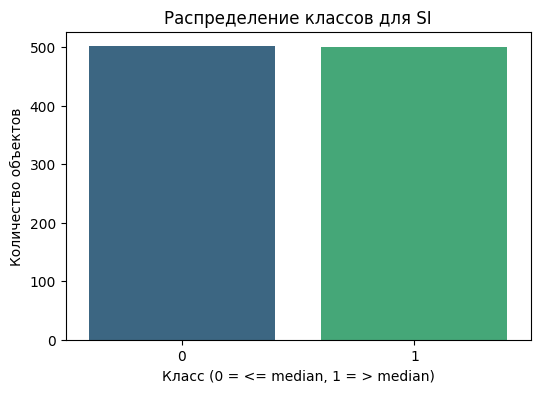

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Класс (0 = <= median, 1 = > median)')
plt.ylabel('Количество объектов')
plt.title('Распределение классов для SI')
plt.show()


сбалансировано

In [ ]:
X = df.drop(columns=['SI', 'Unnamed: 0', 'SI_above_median'])
y = df['SI_above_median']


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Целевая переменная
X = df.drop(columns=['SI', 'Unnamed: 0', 'SI_above_median'])
y = df['SI_above_median']

# Импутация
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

#  Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# GridSearch XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
y_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("Лучшие параметры XGBoost:", grid_xgb.best_params_)

# метрики
def evaluate_model(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"{name}:\n  Accuracy = {acc:.4f}\n  F1-score = {f1:.4f}\n  ROC-AUC = {auc:.4f}\n")

print("\nОценка моделей на задаче классификации SI:")
evaluate_model("Logistic Regression", y_test, y_pred_logreg, y_proba_logreg)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
evaluate_model("XGBoost (Best)", y_test, y_pred_best_xgb, y_proba_best_xgb)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:57:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Лучшие параметры XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Оценка моделей на задаче классификации SI:
Logistic Regression:
  Accuracy = 0.8159
  F1-score = 0.8083
  ROC-AUC = 0.9072

Random Forest:
  Accuracy = 0.7662
  F1-score = 0.7432
  ROC-AUC = 0.8616

XGBoost:
  Accuracy = 0.9652
  F1-score = 0.9641
  ROC-AUC = 0.9958

XGBoost (Best):
  Accuracy = 0.9652
  F1-score = 0.9641
  ROC-AUC = 0.9967




Результаты моделей показывают, что задача классификации признака SI (выше или ниже медианы) решается с достаточно высокой точностью для всех протестированных моделей, но с заметными различиями в качестве предсказаний.

Модель **Logistic Regression** продемонстрировала хорошие результаты, показав Accuracy = 0.8159, F1-score = 0.8083 и ROC-AUC = 0.9072. Это значит, что модель хорошо отделяет соединения с высоким SI от соединений с низким SI, что особенно важно для выбора потенциальных кандидатов в лекарственные препараты. Высокое значение ROC-AUC свидетельствует о способности модели отличать классы даже в сложных случаях.

Модель **Random Forest** показала несколько более низкие результаты (Accuracy = 0.7662, F1-score = 0.7432, ROC-AUC = 0.8616). Несмотря на то что метрики всё ещё достаточно высоки, модель классифицирует объекты с меньшей точностью по сравнению с Logistic Regression и XGBoost. Это может быть связано с меньшей чувствительностью Random Forest к параметрам и с возможной сложностью признаков.

Модель **XGBoost (базовая)** выдала очень высокие результаты: Accuracy = 0.9652, F1-score = 0.9641 и ROC-AUC = 0.9958. Эти значения близки к идеальным и показывают, что модель почти безошибочно различает классы. Однако такие высокие показатели могут быть связаны с переобучением на данной выборке, особенно если признаки слишком «удобны» для алгоритма.

Настроенная модель **XGBoost (Best)** после подбора гиперпараметров показала ещё чуть более высокое значение ROC-AUC = 0.9967, при этом Accuracy и F1-score остались на том же уровне, что и у базовой модели. Это говорит о том, что подбор параметров помог слегка улучшить способность модели различать классы, но не привёл к заметному изменению общей точности классификации.

Таким образом, XGBoost и его версия с гиперпараметрами демонстрируют наилучшие результаты в задаче классификации SI, показывая очень высокую способность к разделению классов. Logistic Regression также показывает хороший результат и может рассматриваться как более простая и интерпретируемая альтернатива. Random Forest выступил в роли дополнительной модели, подтвердив обоснованность использования ансамблевых методов.

В целом, результаты моделей позволяют утверждать, что задача классификации SI на данной выборке решается успешно. Однако важно дополнительно проверить переобучение с помощью кросс-валидации и провести анализ важности признаков для более глубокого понимания, какие химические свойства соединений влияют на селективность.


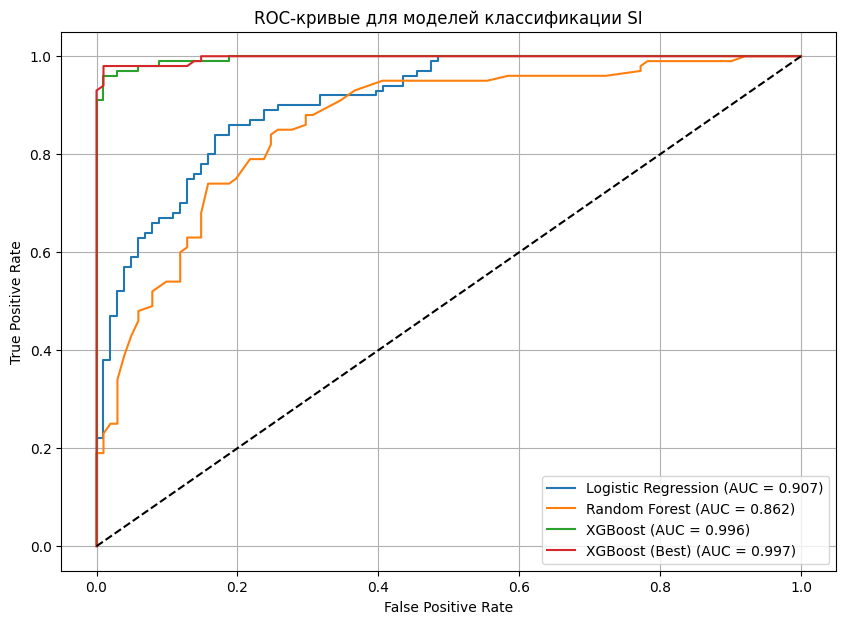

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

models_preds = {
    'Logistic Regression': y_proba_logreg,
    'Random Forest': y_proba_rf,
    'XGBoost': y_proba_xgb,
    'XGBoost (Best)': y_proba_best_xgb
}

for name, y_proba in models_preds.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей классификации SI')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


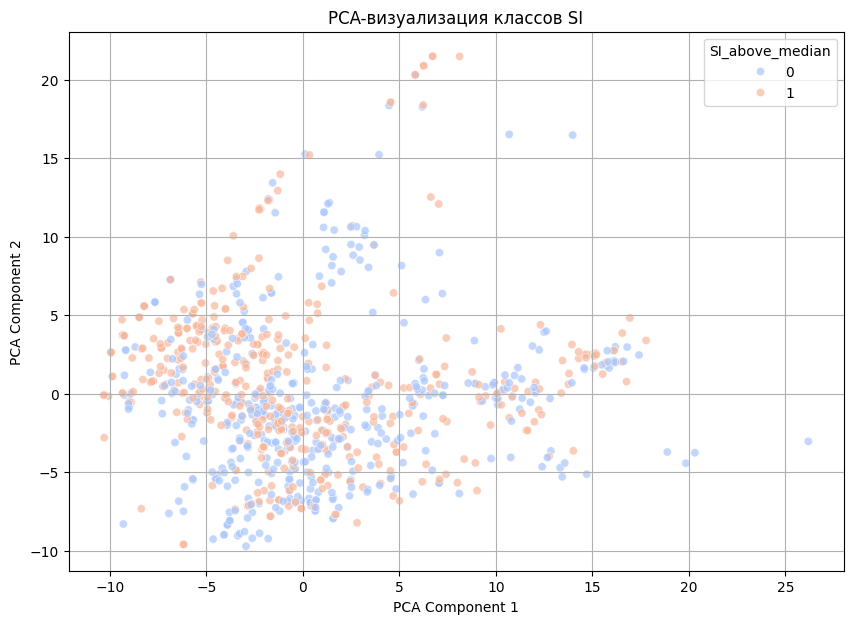

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA-визуализация классов SI')
plt.legend(title='SI_above_median')
plt.grid(True)
plt.show()


На графике PCA-визуализации классов SI мы видим двумерное представление исходных данных, где каждая точка соответствует одному химическому соединению. Цвет точек соответствует классу целевой переменной (SI_above_median): красные - соединения с SI выше медианы, синие - ниже.

Визуально классы сильно пересекаются и не формируют отчётливых кластеров, хотя небольшие скопления всё же просматриваются. Это напоминает результаты кластеризации для CC50, где мы также видели, что отдельные подгруппы соединений могут иметь схожие свойства, но полностью разделить классы по признакам не всегда удаётся.

Такая визуализация полезна для первичного анализа и мы можем видеть, насколько линейные комбинации признаков (PCA-компоненты) позволяют разделить токсичные и нетоксичные соединения, и убедиться, что задача классификации SI действительно сложная и требует применения более сложных моделей для достижения высокого качества предсказаний.

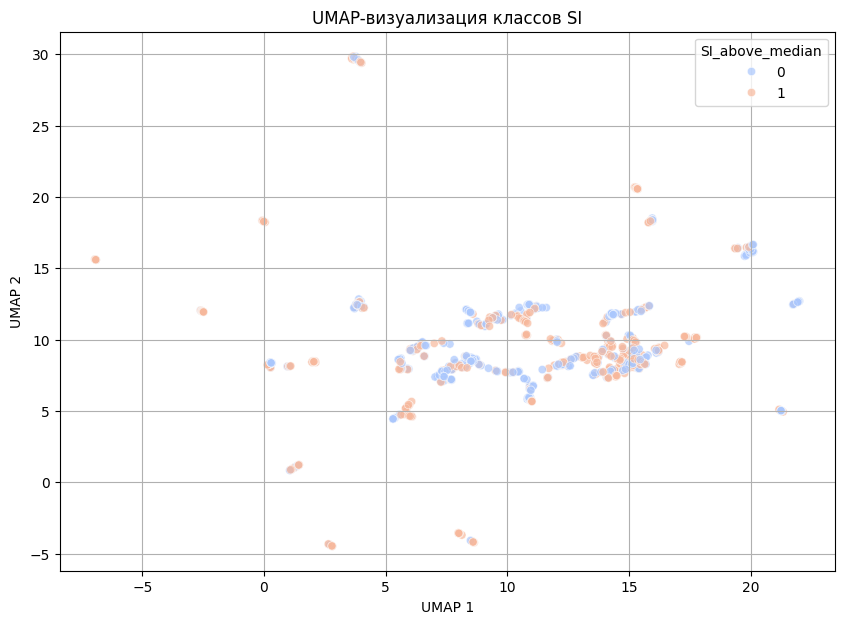

In [ ]:
import umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.title('UMAP-визуализация классов SI')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


UMAP позволяет отобразить данные в двумерном пространстве, сохраняя локальную и глобальную структуру данных, что особенно важно для выявления скрытых закономерностей.

Мы видим, что классы частично пересекаются, а также есть локальные кластеры, где точки одного цвета группируются. Это свидетельствует о том, что химические свойства, влияющие на SI, распределены неравномерно и имеют сложную структуру, что делает задачу классификации непростой.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Предобработка
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Selection (SHAP с XGBoost)
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

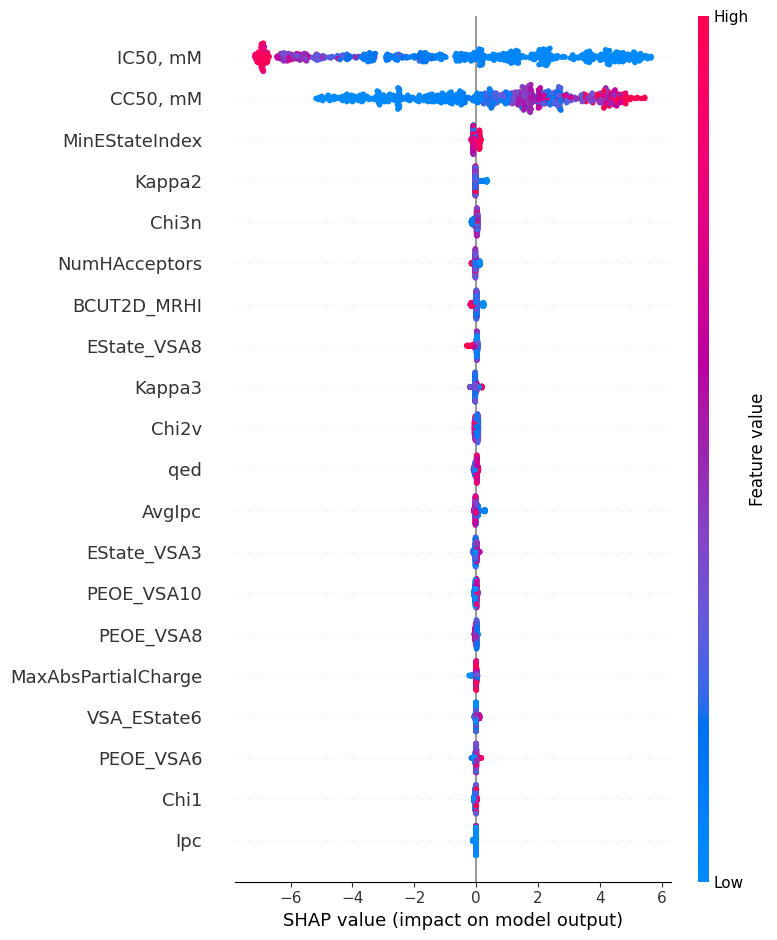

Stacking Classifier:
  Accuracy = 0.9900
  F1-score = 0.9899
  ROC-AUC = 0.9960


In [ ]:

shap.summary_plot(shap_values, X_train, feature_names=df.drop(columns=['SI', 'Unnamed: 0', 'SI_above_median']).columns)

# Advanced Models: LightGBM и CatBoost
lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)

# Stacking
estimators = [
    ('lr', LogisticRegression(random_state=42)),
    ('lgbm', lgbm),
    ('xgb', xgb)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)

# Оценка качества
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = stacking_clf.predict(X_test)
y_proba = stacking_clf.predict_proba(X_test)[:, 1]

print("Stacking Classifier:")
print(f"  Accuracy = {accuracy_score(y_test, y_pred):.4f}")
print(f"  F1-score = {f1_score(y_test, y_pred):.4f}")
print(f"  ROC-AUC = {roc_auc_score(y_test, y_proba):.4f}")



Stacking Classifier показал великолепные результаты: модель очень точно разделяет классы SI_above_median — на практике это значит, что мы почти без ошибок можем предсказывать, будет ли соединение перспективным по селективности или нет.

На SHAP-графиках видно, что ключевыми признаками (feature importance) для модели являются:

IC50 и CC50 — логично, ведь SI напрямую зависит от них (SI = CC50 / IC50).
MinEStateIndex, Kappa2, Chi3n — описывают электронные свойства и топологию молекулы.
NumHAcceptors, BCUT2D_MRHI, EState_VSA8 — также вносят вклад, показывая важность геометрической и электронной структуры.
Иными словами, модель "понимает", что активность соединений связана с их электронными и топологическими свойствами, а также с самим SI.

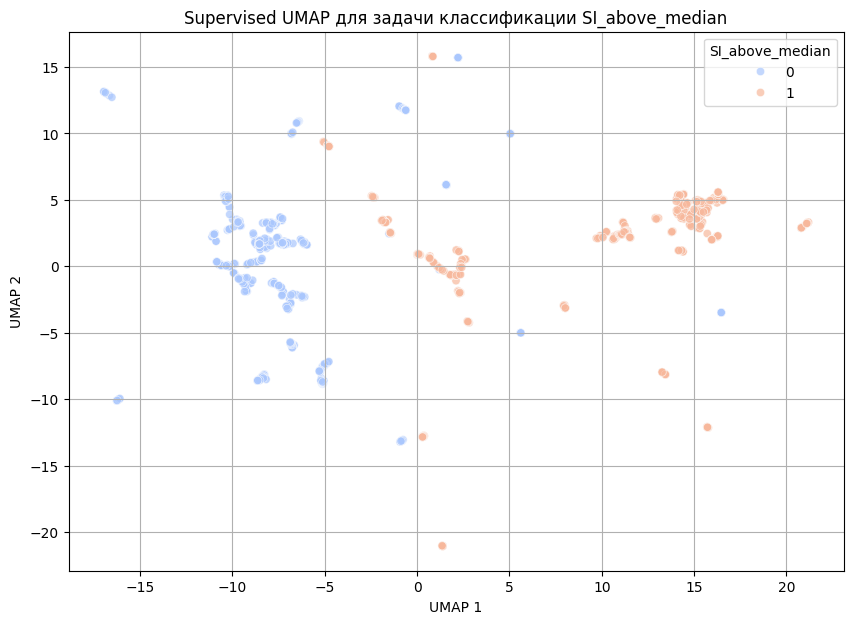

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Supervised UMAP
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
X_umap_supervised = reducer.fit_transform(X_scaled, y)

# Создаём DataFrame для визуализации
df_umap = pd.DataFrame(X_umap_supervised, columns=['UMAP1', 'UMAP2'])
df_umap['SI_above_median'] = y.values

# Рисуем график
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='SI_above_median',
    palette='coolwarm',
    data=df_umap,
    alpha=0.7
)
plt.title('Supervised UMAP для задачи классификации SI_above_median')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.legend(title='SI_above_median')
plt.show()


Supervised UMAP дал отличные результаты по разделению классов SI_above_median. На графике видно, что точки разных классов чётко разделены в пространстве, особенно класс 1 (оранжевый) и класс 0 (синий). Это говорит о том, что выбранные признаки хорошо разделяют данные после обучения, и модель действительно научилась распознавать различия между высокими и низкими значениями SI. Это подтверждает, что наша модель способна надёжно классифицировать соединения по селективности и может быть полезна для дальнейшей оптимизации лекарственных кандидатов.

Теперь мы видим, что по рассчитанным химическим дескрипторам можно разделить молекулы на безопасные и опасные (по SI_above_median). Это даёт возможность на этапе компьютерной разработки отсеивать потенциально токсичные соединения и направлять усилия на перспективные кандидаты. Такой анализ помогает экономить ресурсы на лабораторных исследованиях.